# Plot temperature response over time

This notebook plots temperature respons to SLCFs AND the total scenario forcing. 

## Imports:

In [1]:
import xarray as xr
from IPython.display import clear_output
import numpy as np
import os
import re
from pathlib import Path
import pandas as pd
import tqdm
from scmdata import df_append, ScmDataFrame
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from ar6_ch6_rcmipfigs.utils.plot import get_var_nicename

/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs
/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_in


In [3]:
from ar6_ch6_rcmipfigs.constants import BASE_DIR
from ar6_ch6_rcmipfigs.constants import OUTPUT_DATA_DIR, INPUT_DATA_DIR, RESULTS_DIR

#PATH_DATASET = OUTPUT_DATA_DIR + '/forcing_data_rcmip_models.nc'
#PATH_DT = OUTPUT_DATA_DIR / 'dT_data_rcmip_models.nc'
PATH_DT = OUTPUT_DATA_DIR / 'dT_data_RCMIP.nc'

## Set values:

In [4]:
first_y ='1850'
last_y = '2100'

**Set reference year for temperature change:**

In [5]:
ref_year = '2021'

In [6]:
FIGURE_DIR = RESULTS_DIR / 'figures/'

In [7]:

climatemodel = 'climatemodel'
scenario = 'scenario'
variable = 'variable'
time = 'time'

In [8]:

name_deltaT = 'Delta T'

### Define variables to look at:

In [9]:
# variables to plot:
variables_erf_comp = [
    'ch4',
    'aerosol-total',
    'o3',
    'bc_on_snow']
# total ERFs for anthropogenic and total:
variables_erf_tot = ['total_anthropogenic',
                     'total']
variables_all = variables_erf_comp + variables_erf_tot
# Scenarios to plot:
scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585']#, 'historical']

In [10]:

scenarios_fl = ['ssp119', 'ssp126', 'ssp245', 'ssp370', 'ssp370-lowNTCF-aerchemmip',  # 'ssp370-lowNTCF', Due to mistake here
                'ssp585', 'historical']

scenarios_fl_370 = ['ssp370', 'ssp370-lowNTCF-aerchemmip','ssp370-lowNTCF-gidden'# Due to mistake here
                ]

## Open dataset:

### Integrate:
The code below opens the file generated in [2_compute_delta_T.ipynb](2_compute_delta_T.ipynb) by integrating

\begin{align*} 
\Delta T (t) &= \int_0^t ERF(t') IRF(t-t') dt' \\
\end{align*}

where IRF is the impulse response function and ERF is the effective radiative forcing from RCMIP. 

In [11]:
ds_DT = xr.open_dataset(PATH_DT)

In [12]:
PATH_DT

PosixPath('/home/sarambl/PHD/IPCC/public/AR6_CH6_RCMIPFIGSv2/ar6_ch6_rcmipfigs/data_out/dT_data_RCMIP.nc')

In [13]:
ds_DT#.climatemodel

<xarray.Dataset>
Dimensions:     (percentile: 3, scenario: 10, variable: 17, year: 251)
Coordinates:
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * variable    (variable) object 'co2' 'ch4' 'n2o' ... 'total' 'aerosol-total'
  * scenario    (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-gidden'
  * percentile  (percentile) object '5th percentile' 'median' '95th percentile'
Data variables:
    ERF         (scenario, variable, year) float64 ...
    time        (year) datetime64[ns] ...
    delta_t     (year) float64 ...
    Delta T     (percentile, scenario, variable, year) float64 ...

### Define stuff:

In [14]:
from ar6_ch6_rcmipfigs.utils.misc_func import new_varname
from ar6_ch6_rcmipfigs.utils.plot import get_cmap_dic, get_ls_dic, trans_scen2plotlabel, get_scenario_c_dic, \
    get_scenario_ls_dic
name_deltaT = 'Delta T'
# scenario colors and linestyle
cdic = get_scenario_c_dic()
lsdic = get_scenario_ls_dic()







In [15]:
#variables_dt_comp = [new_varname(var, name_deltaT) for var in variables_erf_comp]

## Compute sum of all SLCF forcers

### Concatinate SLCFs along new dimension:

In [16]:
from ar6_ch6_rcmipfigs.utils.plot import get_scenario_c_dic, get_scenario_ls_dic

In [17]:

s_y = first_y

cdic = get_scenario_c_dic()  # get_cmap_dic(ds_DT[scenario].values)
lsdic = get_scenario_ls_dic()  # _scget_ls_dic(ds_DT[climatemodel].values)

def sum_name(var):
    """
    Returns the name off the sum o
    """
    return f'{var} sum '#|'.join(var.split('|')[0:2]) + '|' + 'All'



# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
# Make list of dataArrays to be concatinated:
for var in variables_erf_comp:
    _lst_f.append(ds_DT['ERF'].sel(variable = var))
    _lst_dt.append(ds_DT[name_deltaT].sel(variable=var))
# Name of new var:
erf_all = sum_name('ERF')
# Name of new var:
dt_all = sum_name( name_deltaT)
#ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
#ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))
dt_totn = dt_all

In [18]:
sum_name = 'Sum SLCFs'
ds_sub = ds_DT.sel(variable=variables_erf_comp)
ds_sum = ds_sub.sum(variable)
ds_sum = ds_sum.assign_coords(coords={variable:sum_name})

ds_sum = xr.concat([ds_sum,ds_DT], dim=variable )

In [19]:
ds_sum#.assign_coords(coords={variable:sum_name})
ds_DT = ds_sum
ds_DT

<xarray.Dataset>
Dimensions:     (percentile: 3, scenario: 10, variable: 18, year: 251)
Coordinates:
  * percentile  (percentile) object '5th percentile' 'median' '95th percentile'
  * year        (year) int64 1850 1851 1852 1853 1854 ... 2097 2098 2099 2100
  * scenario    (scenario) object 'ssp534-over' ... 'ssp370-lowNTCF-gidden'
  * variable    (variable) object 'Sum SLCFs' 'co2' ... 'total' 'aerosol-total'
Data variables:
    time        (year) datetime64[ns] ...
    ERF         (scenario, year, variable) float64 0.008121 0.14 ... -0.4407
    delta_t     (variable, year) float64 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 1.0 1.0
    Delta T     (percentile, scenario, year, variable) float64 0.0005858 ... -0.4295

In [20]:
ds_DT.variable.values

array(['Sum SLCFs', 'co2', 'ch4', 'n2o', 'other_wmghg', 'o3',
       'h2o_stratospheric', 'contrails', 'aerosol-radiation_interactions',
       'aerosol-cloud_interactions', 'bc_on_snow', 'land_use', 'volcanic',
       'solar', 'total_anthropogenic', 'total_natural', 'total',
       'aerosol-total'], dtype=object)

In [21]:
total_varname = 'total_anthropogenic'


s_y = first_y


def sum_name(var):
    """
    Returns the name off the sum o
    """
    return '|'.join(var.split('|')[0:2]) + '|' + 'All'



# make xarray with variable as new dimension:
_lst_f = []
_lst_dt = []
# Make list of dataArrays to be concatinated:
for var in variables_erf_comp:
    _lst_f.append(ds_DT[var])
    _lst_dt.append(ds_DT[new_varname(var, name_deltaT)])
# Name of new var:
erf_all = sum_name('Effective Radiative Forcing|Anthropogenic|all')
# Name of new var:
dt_all = sum_name(new_varname('Effective Radiative Forcing|Anthropogenic|all', name_deltaT))
ds_DT[erf_all] = xr.concat(_lst_f, pd.Index(variables_erf_comp, name='variable'))
ds_DT[dt_all] = xr.concat(_lst_dt, pd.Index(variables_erf_comp, name='variable'))
dt_totn = dt_all

## Plot total $\Delta T$ together with SLCF contribution
In the following plot, the total anthropogenic temperature change in a scenario is showed by the black stipled line, while the contribution of each SLCFer is showed as an shaded area either (cooling) over or under (warming).

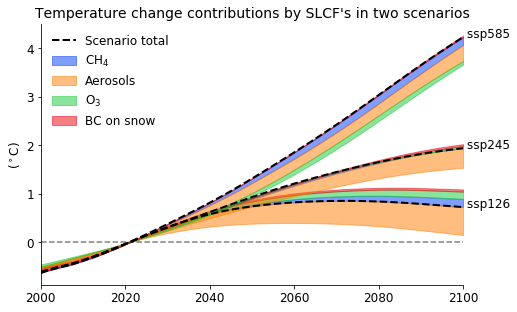

In [27]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = ref_year
s_y2 = '2000'
e_y = last_y
e_y2 = last_y
# Scenarios to plot:
scenarios_ss = ['ssp126','ssp245', 'ssp585']
ref_var_erf = 'ERF'
ref_var_dt =  name_deltaT
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, year=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           year=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic = cdic1#, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    # Plot zero line:
    
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # subtract year 
        _base = _ds[ref_var]#.sel(variable = total_varname)  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          year=slice(s_y2, e_y2)).sel(variable = total_varname)  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        base_keep = _base.sel(percentile='median')#mean(climatemodel)
        basep = _base.sel(percentile='median')
        basem = _base.sel(percentile='median')
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')

        
        scen_ds = _ds[ref_var].sel(scenario = scn, variable = varl) - base_keep
        test_df = scen_ds.sel( percentile='median').to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                label = get_var_nicename(var)
            else:
                label = '_nolegend_'

            _pl_da = _ds[ref_var].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2), percentile='median')#.mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['year'].values, basep, -_pl_da + basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep - _pl_da
            else:
                ax.fill_between(base_keep['year'].values, basem, basem - _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem - _pl_da
        
        if 'Delta T' in ref_var:
            x_val = 2100
            y_val = base_keep.sel(year=int(x_val))
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val )}#, 'rotation': 28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([int(s_y2),int( e_y2)])
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR /'ssp858_126_relative_contrib.png', dpi=300)
    plt.savefig(FIGURE_DIR /'ssp858_126_relative_contrib.pdf', dpi=300)
    plt.show()

In [23]:
ref_var_dt

'Delta T'

## Plot total $\Delta T$ together with SLCF contribution -- reversed
In the following plot, the total anthropogenic temperature change in a scenario is showed by the black stipled line, while the contribution of each SLCFer is showed as an shaded area either (**warming**) over or under (**cooling**).

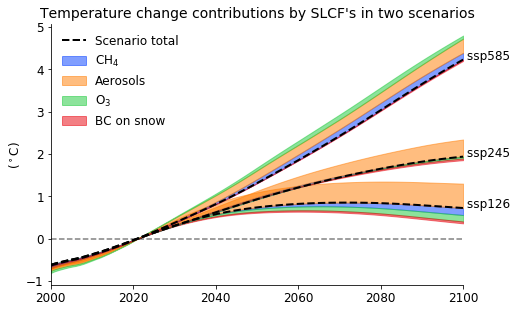

In [28]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = ref_year
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = ['ssp126','ssp245', 'ssp585']
ref_var_erf = 'ERF'
ref_var_dt =  name_deltaT
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, year=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           year=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic = cdic1#, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    # Plot zero line:
    
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # subtract year 
        _base = _ds[ref_var]#.sel(variable = total_varname)  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          year=slice(s_y2, e_y2)).sel(variable = total_varname)  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        base_keep = _base.sel(percentile='median')#mean(climatemodel)
        basep = _base.sel(percentile='median')
        basem = _base.sel(percentile='median')
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')

        
        scen_ds = _ds[ref_var].sel(scenario = scn, variable = varl) - base_keep
        test_df = scen_ds.sel( percentile='median').to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                label =  get_var_nicename(var)#' ' + var.split('|')[-1]
            else:
                label = '_nolegend_'

            _pl_da = _ds[ref_var].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2), percentile='median')#.mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['year'].values, basep+_pl_da, basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep + _pl_da
            else:
                ax.fill_between(base_keep['year'].values, basem, basem + _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem + _pl_da
        
        if 'Delta T' in ref_var:
            x_val = 2100
            y_val = base_keep.sel(year=int(x_val))
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val )}#, 'rotation': 28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([int(s_y2),int( e_y2)])
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    plt.savefig(FIGURE_DIR /'ssp858_126_relative_contrib_rev.png', dpi=300)
    plt.savefig(FIGURE_DIR /'ssp858_126_relative_contrib_rev.pdf', dpi=300)
    plt.show()

In [25]:
scenarios_ss = list(set( scenarios_fl) - {'historical','ssp370-lowNTCF-aerchemmip'})# 'ssp'#['ssp126','ssp245', 'ssp585']

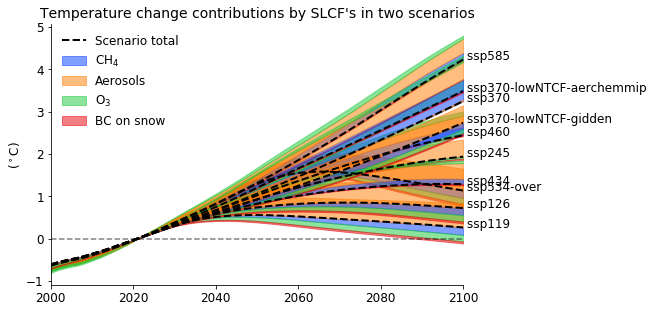

In [26]:
SMALL_SIZE = 12
MEDIUM_SIZE = 12
BIGGER_SIZE = 14

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


s_y = ref_year
s_y2 = '2000'
e_y = '2100'
e_y2 = '2100'

scenarios_ss = ds_DT[scenario].values#['ssp126','ssp245', 'ssp585']
ref_var_erf = 'ERF'
ref_var_dt =  name_deltaT
# make subset and ref to year s_y:
_ds = ds_DT.sel(scenario=scenarios_ss, year=slice(s_y2, e_y2)) - ds_DT.sel(scenario=scenarios_ss,
                                                                           year=slice(s_y, s_y)).squeeze()
cdic1 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic2 = get_cmap_dic(variables_erf_comp, palette='bright')
cdic = cdic1#, **cdic2)
first=True
for ref_var, varl in zip([ref_var_dt],
                             [variables_erf_comp]):
    fig, ax = plt.subplots(1, figsize=[7, 4.5])
    # Plot zero line:
    
    ax.plot(_ds['year'], np.zeros(len(_ds['year'])), c='k', alpha=0.5, linestyle='dashed')
    # print(ref_var)
    for scn in scenarios_ss[:]:
        # subtract year 
        _base = _ds[ref_var]#.sel(variable = total_varname)  # _ds.sel(scenario=scn)
        _base = _base.sel(scenario=scn,
                          year=slice(s_y2, e_y2)).sel(variable = total_varname)  # -_base.sel(scenario=scn, time=slice(s_y, s_y)).squeeze()
        base_keep = _base.sel(percentile='median')#mean(climatemodel)
        basep = _base.sel(percentile='median')
        basem = _base.sel(percentile='median')
        if first:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='Scenario total ')
            first=False
        else:
            base_keep.plot(c='k', linewidth=2, linestyle='dashed', ax=ax, label='_nolegend_')

        
        scen_ds = _ds[ref_var].sel(scenario = scn, variable = varl) - base_keep
        test_df = scen_ds.sel( percentile='median').to_dataframe()
        for var in varl:
            if scn == scenarios_ss[0]:
                label =  var#' ' + var.split('|')[-1]
                label =  get_var_nicename(var)#' ' + var.split('|')[-1]

            else:
                label = '_nolegend_'

            _pl_da = _ds[ref_var].sel(variable=var, scenario=scn, year=slice(s_y2, e_y2), percentile='median')#.mean(climatemodel))  # -base_keep)
            if _pl_da.mean() <= 0:
                # print(var)

                ax.fill_between(base_keep['year'].values, basep+_pl_da, basep, alpha=0.5,
                                color=cdic[var], label=label)
                basep = basep + _pl_da
            else:
                ax.fill_between(base_keep['year'].values, basem, basem + _pl_da, alpha=0.5,
                                color=cdic[var], label=label)
                basem = basem + _pl_da
        
        if 'Delta T' in ref_var:
            x_val = 2100
            y_val = base_keep.sel(year=int(x_val))
            if scn == 'ssp585':
                kwargs = {'xy': (x_val, y_val )}#, 'rotation': 28.6}
            else:
                kwargs = {'xy': (x_val, y_val )}
            #ax.annotate('$\Delta$T, %s' % scn, **kwargs)
            ax.annotate(' %s' % scn, **kwargs)

    ax.legend(frameon=False, loc=2)
    
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    
    ax.set_xlim([int(s_y2),int( e_y2)])
    ax.set_ylabel('($^\circ$C)')
    ax.set_xlabel('')
    plt.title('Temperature change contributions by SLCF\'s in two scenarios', fontsize=14)
    plt.tight_layout()
    #plt.savefig(FIGURE_DIR /'ssp858_126_relative_contrib_rev.png', dpi=300)
    plt.show()

## What question does the graph answer?
- What are the relative contributions of SLCFs?
    - The figure above shows the contributions of 5 SLCFs and the total anthropogenic forcing in two scenarios (black line) relative to year 2021. The area signifies the warming (below the total) or cooling (above the stipled line) introduced by changes in the SLCFer in the specific scenario. Note that in the in the businiss as usual scenario, all the SLCFers except BC on snow add to the warming, while in the 126 scenario, the emission control acts to reduce methane, ozone and BC, and these are thus contributing to cooling. Both scenarios include emission controls which act to reduce aerosols relative 2021 and thus the aerosols give warming. However, the warming from aerosols is much stronger in ssp126 because of stricter emission control in this scenario. 

